In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold, train_test_split

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.feature_extraction import DictVectorizer

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from xgboost import XGBRegressor

import catboost as ctb

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display
from tqdm import tqdm

%matplotlib inline

In [7]:
def data_preprocession(data, features):
    """
    """
    mask = data.sellingprice > 1
    df = data[mask].copy()
        
    df.dropna(inplace=True)

    df["age"] = pd.to_datetime(df.saledate).apply(lambda x: x.year) - df.year

    for col in df.select_dtypes(["object"]).columns:
        df[col] = df[col].str.lower().str.replace(" ", "_")
    
    df.sellingprice = np.log1p(df.sellingprice)
        
    return df[features]

In [3]:
data = pd.read_csv("./dataset/car_prices_full_train.csv", sep=',', header='infer')

In [22]:
def train_linear_model(df, model=None, **kwargs):
    
    numerical_features = df.select_dtypes("number").columns.to_list()
    numerical_features.remove("sellingprice")

    rmse_scores = []
    mape_scores = []
    mae_scores = []

    kfold = KFold(n_splits=5, shuffle=True, random_state=2)

    for idx_train, idx_valid in tqdm(kfold.split(df)):
        
        df_train = df.iloc[idx_train].copy()
        df_train.reset_index(drop=True)
        y_train = df_train.pop("sellingprice")

        df_valid = df.iloc[idx_valid].copy()
        df_valid.reset_index(drop=True)
        y_valid = df_valid.pop("sellingprice")
        
        ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1)

        df_train["seller"] = ordinal.fit_transform(df_train["seller"].values.reshape(-1,1))
        df_valid["seller"] = ordinal.transform(df_valid["seller"].values.reshape(-1,1))

        scaler = StandardScaler()

        df_train[numerical_features + ["seller"]] = scaler.fit_transform(df_train[numerical_features + ["seller"]])
        df_valid[numerical_features + ["seller"]] = scaler.transform(df_valid[numerical_features + ["seller"]])

        df_train[numerical_features] = scaler.fit_transform(df_train[numerical_features])
        df_valid[numerical_features] = scaler.transform(df_valid[numerical_features])

        dict_train = df_train.to_dict(orient="records")
        dict_valid = df_valid.to_dict(orient="records")

        
        dv = DictVectorizer(sparse=True)
        X_train = dv.fit_transform(dict_train)
        X_valid = dv.transform(dict_valid)

        regression_model = model(**kwargs)
        
        if model == XGBRegressor:
            fitting_params = {
                "X": X_train,
                "y": y_train,
                "eval_set": [(X_train, y_train), (X_valid, y_valid)]
            }
        else:
            fitting_params = {
                "X": X_train,
                "y": y_train,
            }

        # regression_model.fit(X_train, y_train)
        regression_model.fit(**fitting_params)

        y_valid_predict = regression_model.predict(X_valid)

        rmse = mean_squared_error(y_valid, y_valid_predict, squared=False)
        mape = mean_absolute_percentage_error(y_valid, y_valid_predict)
        mae = mean_absolute_error(y_valid, y_valid_predict)

        rmse_scores.append(rmse)
        mape_scores.append(mape)
        mae_scores.append(mae)

    return kwargs, np.mean(rmse_scores), np.mean(mape_scores), np.mean(mae_scores)


In [70]:
def plot_scores(logs, param_name, tuned_param=tuned_param, ylim=[0.21, 0.24], folds=5, n_estimators=250):

    logs_tab = [record.split('\t') for record in logs.split('\n')[:-1]]
    log_scores = []

    for log in logs_tab:
        scores_dict = {}
        scores_dict["n_iter"] = log[0].strip('[]')
        scores_dict["train-rmse"] = float(log[1].split(":")[1])
        scores_dict["valid-rmse"] = float(log[2].split(":")[1])

        log_scores.append(scores_dict)

    scores_df = pd.DataFrame(log_scores)

    scores_dict = {
        p: df
            for p, df in zip(tuned_param, scores_df.values.reshape(-1, 3*n_estimators*folds))
    }

    scores = {}

    for param in scores_dict.keys():

        fold_scores = pd.DataFrame(scores_dict[param].reshape(-1,3), columns=["n_iter", "train-rmse", "valid-rmse"])
        fold_scores["n_iter"] = fold_scores["n_iter"].astype("int")
        
        scores[param] = fold_scores.groupby("n_iter", as_index=False).agg("mean")
    
    
    cmap = plt.get_cmap('plasma')
    colors_grid = np.linspace(0, 1, len(scores.keys()))

    plt.figure(figsize=(12,4))
    for param, color in zip(scores.keys(), cmap(colors_grid)) :
        plt.plot(scores[param]["valid-rmse"].index, scores[param]["valid-rmse"], color=color , label=f"{param_name}={param}")

    plt.ylim(ylim)
    plt.grid()
    plt.legend()
    plt.show()

    return scores

In [44]:
features = [
    'year',
    'make',
    'model',
    'trim',
    'body',
    'state',
    'condition',
    'odometer',
    # 'color',
    # 'interior',
    # 'transmission',
    'seller',
    'sellingprice',
    'age'
    ]

df = data_preprocession(data, features=features)

In [24]:
alphas = [0.001, 0.01, 0.1, 1, 5, 10, 100]

training_metrics = []
for alpha in tqdm(alphas):
    scores = {}
    scores["params"], scores["rmse"], scores["mape"], scores["mae"] = train_linear_model(df, model=Ridge, alpha=alpha)
    
    training_metrics.append(scores)


df_metrics = pd.DataFrame(training_metrics)
display(df_metrics.sort_values(by="rmse"))

5it [00:27,  5.50s/it]00:00<?, ?it/s]
5it [00:29,  5.85s/it]00:27<02:45, 27.59s/it]
5it [00:28,  5.66s/it]00:57<02:23, 28.67s/it]
5it [00:29,  5.80s/it]01:25<01:54, 28.56s/it]
5it [00:29,  5.90s/it]01:54<01:26, 28.78s/it]
5it [00:27,  5.54s/it]02:24<00:58, 29.10s/it]
5it [00:28,  5.67s/it]02:52<00:28, 28.66s/it]
100%|██████████| 7/7 [03:20<00:00, 28.65s/it]


,params,rmse,mape,mae
2,{'alpha': 0.1},0.264127,0.020173,0.171922
0,{'alpha': 0.001},0.264445,0.020200,0.172192
1,{'alpha': 0.01},0.264450,0.020201,0.172198
3,{'alpha': 1},0.264598,0.020213,0.172306
4,{'alpha': 5},0.264856,0.020237,0.172535
5,{'alpha': 10},0.266115,0.020348,0.173567
6,{'alpha': 100},0.277743,0.021347,0.182801


In [25]:
# Full feature training results

alpha = 0.1
model = Ridge

df_full_train = df.copy()
y_full_train = df_full_train.pop("sellingprice")

numerical_features = df_full_train.select_dtypes("number").columns.to_list()

ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1)

df_full_train["seller"] = ordinal.fit_transform(df_full_train["seller"].values.reshape(-1,1))

scaler = StandardScaler()

df_full_train[numerical_features + ["seller"]] = scaler.fit_transform(df_full_train[numerical_features + ["seller"]])

# df_valid["seller"] = ordinal.transform(df_valid["seller"].values.reshape(-1,1))
# df_valid[numerical_features + ["seller"]] = scaler.transform(df_valid[numerical_features + ["seller"]])

dict_full_train = df_full_train.to_dict(orient="records")
               
dv = DictVectorizer(sparse=True)
X_full_train = dv.fit_transform(dict_full_train)

lin_reg = model(alpha=alpha)

lin_reg.fit(X_full_train, y_full_train)

y_predict = lin_reg.predict(X_full_train)

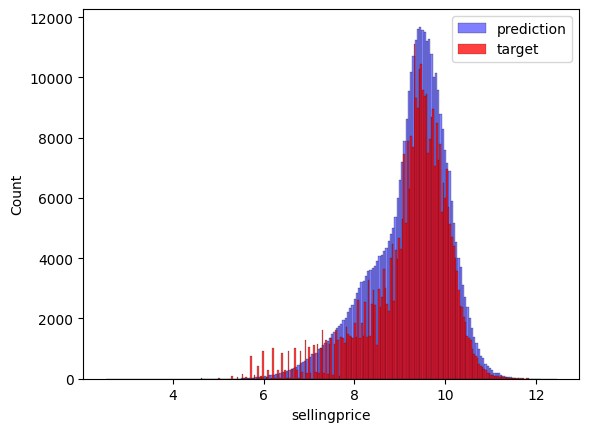

In [40]:
sns.histplot(y_predict, bins=200, color='b', alpha=0.5, label="prediction")
sns.histplot(y_full_train, bins=200, color='r', label="target")

plt.legend()
plt.show()

Random Forest Regression

In [53]:
features = [
    'year',
    'make',
    'model',
    'trim',
    'body',
    'state',
    'condition',
    'odometer',
    'seller',
    'sellingprice',
    'age'
    ]

df_filtered = data_preprocession(data, features=features)

params = {
    "n_estimators": 50,
    "n_jobs": 4,
}

max_depths = [10, 30, 50,] #[5, 10, 30, 50, 100]

training_metrics = []
for max_depth in tqdm(max_depths):
    scores = {}
    scores["params"], scores["rmse"], scores["mape"], scores["mae"] = train_linear_model(df, model=RandomForestRegressor, max_depth=max_depth, **params)
    
    print(scores)
    training_metrics.append(scores)


df_metrics = pd.DataFrame(training_metrics)
display(df_metrics.sort_values(by="rmse"))

5it [04:42, 56.49s/it]00:00<?, ?it/s]
 33%|███▎      | 1/3 [04:42<09:25, 282.58s/it]

{'params': {'max_depth': 10, 'n_estimators': 50, 'n_jobs': 4}, 'rmse': 0.1407575085642897, 'mape': 0.030740956926619593, 'mae': 0.26896598621181467}


5it [58:00, 696.13s/it]
 67%|██████▋   | 2/3 [1:02:43<36:03, 2163.89s/it]

{'params': {'max_depth': 30, 'n_estimators': 50, 'n_jobs': 4}, 'rmse': 0.06417684506826843, 'mape': 0.01868568159780792, 'mae': 0.15897232198917535}


5it [1:30:26, 1085.31s/it]
100%|██████████| 3/3 [2:33:10<00:00, 3063.36s/it]

{'params': {'max_depth': 50, 'n_estimators': 50, 'n_jobs': 4}, 'rmse': 0.05669532981280436, 'mape': 0.01684527475043967, 'mae': 0.1414799909378329}


,params,rmse,mape,mae
2,"{'max_depth': 50, 'n_estimators': 50, 'n_jobs'...",0.056695,0.016845,0.141480
1,"{'max_depth': 30, 'n_estimators': 50, 'n_jobs'...",0.064177,0.018686,0.158972
0,"{'max_depth': 10, 'n_estimators': 50, 'n_jobs'...",0.140758,0.030741,0.268966


XGBoost Regressor

In [236]:
features = [
    'year',
    'make',
    'model',
    'trim',
    'body',
    # 'state',
    'condition',
    'odometer',
    'seller',
    'sellingprice',
    'age'
    ]

df_filtered = data_preprocession(data, features=features)


  0%|          | 0/10 [00:00<?, ?it/s]

[0]	validation_0-rmse:6.15150	validation_1-rmse:6.14910
[1]	validation_0-rmse:4.31755	validation_1-rmse:4.31604
[2]	validation_0-rmse:3.03701	validation_1-rmse:3.03597
[3]	validation_0-rmse:2.14561	validation_1-rmse:2.14554
[4]	validation_0-rmse:1.52782	validation_1-rmse:1.52805
[5]	validation_0-rmse:1.10372	validation_1-rmse:1.10429
[6]	validation_0-rmse:0.81655	validation_1-rmse:0.81736
[7]	validation_0-rmse:0.62773	validation_1-rmse:0.62874
[8]	validation_0-rmse:0.50740	validation_1-rmse:0.50875
[9]	validation_0-rmse:0.43445	validation_1-rmse:0.43605


[0]	validation_0-rmse:6.15096	validation_1-rmse:6.15097
[1]	validation_0-rmse:4.31711	validation_1-rmse:4.31730
[2]	validation_0-rmse:3.03664	validation_1-rmse:3.03692
[3]	validation_0-rmse:2.14535	validation_1-rmse:2.14567
[4]	validation_0-rmse:1.52773	validation_1-rmse:1.52850
[5]	validation_0-rmse:1.10292	validation_1-rmse:1.10434
[6]	validation_0-rmse:0.81639	validation_1-rmse:0.81828
[7]	validation_0-rmse:0.62753	validation_1-rmse:0.63024
[8]	validation_0-rmse:0.50679	validation_1-rmse:0.51048
[9]	validation_0-rmse:0.43409	validation_1-rmse:0.43838


[0]	validation_0-rmse:6.14990	validation_1-rmse:6.15610
[1]	validation_0-rmse:4.31640	validation_1-rmse:4.32128
[2]	validation_0-rmse:3.03626	validation_1-rmse:3.04002
[3]	validation_0-rmse:2.14516	validation_1-rmse:2.14827
[4]	validation_0-rmse:1.52782	validation_1-rmse:1.53070
[5]	validation_0-rmse:1.10315	validation_1-rmse:1.10573
[6]	validation_0-rmse:0.81698	validation_1-rmse:0.81947
[7]	validation_0-rmse:0.62811	validation_1-rmse:0.63045
[8]	validation_0-rmse:0.50721	validation_1-rmse:0.50936
[9]	validation_0-rmse:0.43436	validation_1-rmse:0.43680


[0]	validation_0-rmse:6.15169	validation_1-rmse:6.14779
[1]	validation_0-rmse:4.31761	validation_1-rmse:4.31477
[2]	validation_0-rmse:3.03712	validation_1-rmse:3.03483
[3]	validation_0-rmse:2.14567	validation_1-rmse:2.14373
[4]	validation_0-rmse:1.52822	validation_1-rmse:1.52683
[5]	validation_0-rmse:1.10422	validation_1-rmse:1.10325
[6]	validation_0-rmse:0.81721	validation_1-rmse:0.81601
[7]	validation_0-rmse:0.62877	validation_1-rmse:0.62784
[8]	validation_0-rmse:0.50861	validation_1-rmse:0.50799
[9]	validation_0-rmse:0.43564	validation_1-rmse:0.43564


[0]	validation_0-rmse:6.15087	validation_1-rmse:6.15107
[1]	validation_0-rmse:4.31693	validation_1-rmse:4.31697
[2]	validation_0-rmse:3.03667	validation_1-rmse:3.03622
[3]	validation_0-rmse:2.14546	validation_1-rmse:2.14503
[4]	validation_0-rmse:1.52770	validation_1-rmse:1.52736
[5]	validation_0-rmse:1.10382	validation_1-rmse:1.10360
[6]	validation_0-rmse:0.81734	validation_1-rmse:0.81733
[7]	validation_0-rmse:0.62905	validation_1-rmse:0.62955
[8]	validation_0-rmse:0.50900	validation_1-rmse:0.50990
[9]	validation_0-rmse:0.43587	validation_1-rmse:0.43682


5it [00:32,  6.42s/it]
 10%|█         | 1/10 [00:32<04:50, 32.25s/it]

[0]	validation_0-rmse:6.15150	validation_1-rmse:6.14910
[1]	validation_0-rmse:4.31755	validation_1-rmse:4.31604
[2]	validation_0-rmse:3.03701	validation_1-rmse:3.03597
[3]	validation_0-rmse:2.14561	validation_1-rmse:2.14554
[4]	validation_0-rmse:1.52782	validation_1-rmse:1.52805
[5]	validation_0-rmse:1.10372	validation_1-rmse:1.10429
[6]	validation_0-rmse:0.81655	validation_1-rmse:0.81736
[7]	validation_0-rmse:0.62773	validation_1-rmse:0.62874
[8]	validation_0-rmse:0.50740	validation_1-rmse:0.50875
[9]	validation_0-rmse:0.43445	validation_1-rmse:0.43605
[10]	validation_0-rmse:0.39093	validation_1-rmse:0.39241
[11]	validation_0-rmse:0.36524	validation_1-rmse:0.36633
[12]	validation_0-rmse:0.34970	validation_1-rmse:0.35107
[13]	validation_0-rmse:0.33982	validation_1-rmse:0.34164
[14]	validation_0-rmse:0.33276	validation_1-rmse:0.33478
[15]	validation_0-rmse:0.32688	validation_1-rmse:0.32900
[16]	validation_0-rmse:0.32266	validation_1-rmse:0.32487
[17]	validation_0-rmse:0.31951	validation

[0]	validation_0-rmse:6.15096	validation_1-rmse:6.15097
[1]	validation_0-rmse:4.31711	validation_1-rmse:4.31730
[2]	validation_0-rmse:3.03664	validation_1-rmse:3.03692
[3]	validation_0-rmse:2.14535	validation_1-rmse:2.14567
[4]	validation_0-rmse:1.52773	validation_1-rmse:1.52850
[5]	validation_0-rmse:1.10292	validation_1-rmse:1.10434
[6]	validation_0-rmse:0.81639	validation_1-rmse:0.81828
[7]	validation_0-rmse:0.62753	validation_1-rmse:0.63024
[8]	validation_0-rmse:0.50679	validation_1-rmse:0.51048
[9]	validation_0-rmse:0.43409	validation_1-rmse:0.43838
[10]	validation_0-rmse:0.39094	validation_1-rmse:0.39585
[11]	validation_0-rmse:0.36522	validation_1-rmse:0.37026
[12]	validation_0-rmse:0.34965	validation_1-rmse:0.35474
[13]	validation_0-rmse:0.33968	validation_1-rmse:0.34504
[14]	validation_0-rmse:0.33162	validation_1-rmse:0.33735
[15]	validation_0-rmse:0.32573	validation_1-rmse:0.33148
[16]	validation_0-rmse:0.32126	validation_1-rmse:0.32729
[17]	validation_0-rmse:0.31473	validation

[0]	validation_0-rmse:6.14990	validation_1-rmse:6.15610
[1]	validation_0-rmse:4.31640	validation_1-rmse:4.32128
[2]	validation_0-rmse:3.03626	validation_1-rmse:3.04002
[3]	validation_0-rmse:2.14516	validation_1-rmse:2.14827
[4]	validation_0-rmse:1.52782	validation_1-rmse:1.53070
[5]	validation_0-rmse:1.10315	validation_1-rmse:1.10573
[6]	validation_0-rmse:0.81698	validation_1-rmse:0.81947
[7]	validation_0-rmse:0.62811	validation_1-rmse:0.63045
[8]	validation_0-rmse:0.50721	validation_1-rmse:0.50936
[9]	validation_0-rmse:0.43436	validation_1-rmse:0.43680
[10]	validation_0-rmse:0.39127	validation_1-rmse:0.39342
[11]	validation_0-rmse:0.36563	validation_1-rmse:0.36801
[12]	validation_0-rmse:0.35075	validation_1-rmse:0.35321
[13]	validation_0-rmse:0.34009	validation_1-rmse:0.34257
[14]	validation_0-rmse:0.33364	validation_1-rmse:0.33633
[15]	validation_0-rmse:0.32837	validation_1-rmse:0.33087
[16]	validation_0-rmse:0.32401	validation_1-rmse:0.32666
[17]	validation_0-rmse:0.32074	validation

[0]	validation_0-rmse:6.15169	validation_1-rmse:6.14779
[1]	validation_0-rmse:4.31761	validation_1-rmse:4.31477
[2]	validation_0-rmse:3.03712	validation_1-rmse:3.03483
[3]	validation_0-rmse:2.14567	validation_1-rmse:2.14373
[4]	validation_0-rmse:1.52822	validation_1-rmse:1.52683
[5]	validation_0-rmse:1.10422	validation_1-rmse:1.10325
[6]	validation_0-rmse:0.81721	validation_1-rmse:0.81601
[7]	validation_0-rmse:0.62877	validation_1-rmse:0.62784
[8]	validation_0-rmse:0.50861	validation_1-rmse:0.50799
[9]	validation_0-rmse:0.43564	validation_1-rmse:0.43564
[10]	validation_0-rmse:0.39140	validation_1-rmse:0.39165
[11]	validation_0-rmse:0.36528	validation_1-rmse:0.36569
[12]	validation_0-rmse:0.34991	validation_1-rmse:0.35047
[13]	validation_0-rmse:0.34016	validation_1-rmse:0.34065
[14]	validation_0-rmse:0.33291	validation_1-rmse:0.33387
[15]	validation_0-rmse:0.32733	validation_1-rmse:0.32857
[16]	validation_0-rmse:0.32366	validation_1-rmse:0.32496
[17]	validation_0-rmse:0.31989	validation

[0]	validation_0-rmse:6.15087	validation_1-rmse:6.15107
[1]	validation_0-rmse:4.31693	validation_1-rmse:4.31697
[2]	validation_0-rmse:3.03667	validation_1-rmse:3.03622
[3]	validation_0-rmse:2.14546	validation_1-rmse:2.14503
[4]	validation_0-rmse:1.52770	validation_1-rmse:1.52736
[5]	validation_0-rmse:1.10382	validation_1-rmse:1.10360
[6]	validation_0-rmse:0.81734	validation_1-rmse:0.81733
[7]	validation_0-rmse:0.62905	validation_1-rmse:0.62955
[8]	validation_0-rmse:0.50900	validation_1-rmse:0.50990
[9]	validation_0-rmse:0.43587	validation_1-rmse:0.43682
[10]	validation_0-rmse:0.39181	validation_1-rmse:0.39320
[11]	validation_0-rmse:0.36618	validation_1-rmse:0.36789
[12]	validation_0-rmse:0.35058	validation_1-rmse:0.35224
[13]	validation_0-rmse:0.34118	validation_1-rmse:0.34293
[14]	validation_0-rmse:0.33456	validation_1-rmse:0.33647
[15]	validation_0-rmse:0.32975	validation_1-rmse:0.33178
[16]	validation_0-rmse:0.32425	validation_1-rmse:0.32638
[17]	validation_0-rmse:0.31961	validation

5it [00:48,  9.60s/it]
 20%|██        | 2/10 [01:20<05:32, 41.61s/it]

[0]	validation_0-rmse:6.15150	validation_1-rmse:6.14910
[1]	validation_0-rmse:4.31755	validation_1-rmse:4.31604
[2]	validation_0-rmse:3.03701	validation_1-rmse:3.03597
[3]	validation_0-rmse:2.14561	validation_1-rmse:2.14554
[4]	validation_0-rmse:1.52782	validation_1-rmse:1.52805
[5]	validation_0-rmse:1.10372	validation_1-rmse:1.10429
[6]	validation_0-rmse:0.81655	validation_1-rmse:0.81736
[7]	validation_0-rmse:0.62773	validation_1-rmse:0.62874
[8]	validation_0-rmse:0.50740	validation_1-rmse:0.50875
[9]	validation_0-rmse:0.43445	validation_1-rmse:0.43605
[10]	validation_0-rmse:0.39093	validation_1-rmse:0.39241
[11]	validation_0-rmse:0.36524	validation_1-rmse:0.36633
[12]	validation_0-rmse:0.34970	validation_1-rmse:0.35107
[13]	validation_0-rmse:0.33982	validation_1-rmse:0.34164
[14]	validation_0-rmse:0.33276	validation_1-rmse:0.33478
[15]	validation_0-rmse:0.32688	validation_1-rmse:0.32900
[16]	validation_0-rmse:0.32266	validation_1-rmse:0.32487
[17]	validation_0-rmse:0.31951	validation

[0]	validation_0-rmse:6.15096	validation_1-rmse:6.15097
[1]	validation_0-rmse:4.31711	validation_1-rmse:4.31730
[2]	validation_0-rmse:3.03664	validation_1-rmse:3.03692
[3]	validation_0-rmse:2.14535	validation_1-rmse:2.14567
[4]	validation_0-rmse:1.52773	validation_1-rmse:1.52850
[5]	validation_0-rmse:1.10292	validation_1-rmse:1.10434
[6]	validation_0-rmse:0.81639	validation_1-rmse:0.81828
[7]	validation_0-rmse:0.62753	validation_1-rmse:0.63024
[8]	validation_0-rmse:0.50679	validation_1-rmse:0.51048
[9]	validation_0-rmse:0.43409	validation_1-rmse:0.43838
[10]	validation_0-rmse:0.39094	validation_1-rmse:0.39585
[11]	validation_0-rmse:0.36522	validation_1-rmse:0.37026
[12]	validation_0-rmse:0.34965	validation_1-rmse:0.35474
[13]	validation_0-rmse:0.33968	validation_1-rmse:0.34504
[14]	validation_0-rmse:0.33162	validation_1-rmse:0.33735
[15]	validation_0-rmse:0.32573	validation_1-rmse:0.33148
[16]	validation_0-rmse:0.32126	validation_1-rmse:0.32729
[17]	validation_0-rmse:0.31473	validation

[0]	validation_0-rmse:6.14990	validation_1-rmse:6.15610
[1]	validation_0-rmse:4.31640	validation_1-rmse:4.32128
[2]	validation_0-rmse:3.03626	validation_1-rmse:3.04002
[3]	validation_0-rmse:2.14516	validation_1-rmse:2.14827
[4]	validation_0-rmse:1.52782	validation_1-rmse:1.53070
[5]	validation_0-rmse:1.10315	validation_1-rmse:1.10573
[6]	validation_0-rmse:0.81698	validation_1-rmse:0.81947
[7]	validation_0-rmse:0.62811	validation_1-rmse:0.63045
[8]	validation_0-rmse:0.50721	validation_1-rmse:0.50936
[9]	validation_0-rmse:0.43436	validation_1-rmse:0.43680
[10]	validation_0-rmse:0.39127	validation_1-rmse:0.39342
[11]	validation_0-rmse:0.36563	validation_1-rmse:0.36801
[12]	validation_0-rmse:0.35075	validation_1-rmse:0.35321
[13]	validation_0-rmse:0.34009	validation_1-rmse:0.34257
[14]	validation_0-rmse:0.33364	validation_1-rmse:0.33633
[15]	validation_0-rmse:0.32837	validation_1-rmse:0.33087
[16]	validation_0-rmse:0.32401	validation_1-rmse:0.32666
[17]	validation_0-rmse:0.32074	validation

[0]	validation_0-rmse:6.15169	validation_1-rmse:6.14779
[1]	validation_0-rmse:4.31761	validation_1-rmse:4.31477
[2]	validation_0-rmse:3.03712	validation_1-rmse:3.03483
[3]	validation_0-rmse:2.14567	validation_1-rmse:2.14373
[4]	validation_0-rmse:1.52822	validation_1-rmse:1.52683
[5]	validation_0-rmse:1.10422	validation_1-rmse:1.10325
[6]	validation_0-rmse:0.81721	validation_1-rmse:0.81601
[7]	validation_0-rmse:0.62877	validation_1-rmse:0.62784
[8]	validation_0-rmse:0.50861	validation_1-rmse:0.50799
[9]	validation_0-rmse:0.43564	validation_1-rmse:0.43564
[10]	validation_0-rmse:0.39140	validation_1-rmse:0.39165
[11]	validation_0-rmse:0.36528	validation_1-rmse:0.36569
[12]	validation_0-rmse:0.34991	validation_1-rmse:0.35047
[13]	validation_0-rmse:0.34016	validation_1-rmse:0.34065
[14]	validation_0-rmse:0.33291	validation_1-rmse:0.33387
[15]	validation_0-rmse:0.32733	validation_1-rmse:0.32857
[16]	validation_0-rmse:0.32366	validation_1-rmse:0.32496
[17]	validation_0-rmse:0.31989	validation

[0]	validation_0-rmse:6.15087	validation_1-rmse:6.15107
[1]	validation_0-rmse:4.31693	validation_1-rmse:4.31697
[2]	validation_0-rmse:3.03667	validation_1-rmse:3.03622
[3]	validation_0-rmse:2.14546	validation_1-rmse:2.14503
[4]	validation_0-rmse:1.52770	validation_1-rmse:1.52736
[5]	validation_0-rmse:1.10382	validation_1-rmse:1.10360
[6]	validation_0-rmse:0.81734	validation_1-rmse:0.81733
[7]	validation_0-rmse:0.62905	validation_1-rmse:0.62955
[8]	validation_0-rmse:0.50900	validation_1-rmse:0.50990
[9]	validation_0-rmse:0.43587	validation_1-rmse:0.43682
[10]	validation_0-rmse:0.39181	validation_1-rmse:0.39320
[11]	validation_0-rmse:0.36618	validation_1-rmse:0.36789
[12]	validation_0-rmse:0.35058	validation_1-rmse:0.35224
[13]	validation_0-rmse:0.34118	validation_1-rmse:0.34293
[14]	validation_0-rmse:0.33456	validation_1-rmse:0.33647
[15]	validation_0-rmse:0.32975	validation_1-rmse:0.33178
[16]	validation_0-rmse:0.32425	validation_1-rmse:0.32638
[17]	validation_0-rmse:0.31961	validation

5it [01:02, 12.55s/it]
 30%|███       | 3/10 [02:23<05:59, 51.33s/it]

[0]	validation_0-rmse:6.15150	validation_1-rmse:6.14910
[1]	validation_0-rmse:4.31755	validation_1-rmse:4.31604
[2]	validation_0-rmse:3.03701	validation_1-rmse:3.03597
[3]	validation_0-rmse:2.14561	validation_1-rmse:2.14554
[4]	validation_0-rmse:1.52782	validation_1-rmse:1.52805
[5]	validation_0-rmse:1.10372	validation_1-rmse:1.10429
[6]	validation_0-rmse:0.81655	validation_1-rmse:0.81736
[7]	validation_0-rmse:0.62773	validation_1-rmse:0.62874
[8]	validation_0-rmse:0.50740	validation_1-rmse:0.50875
[9]	validation_0-rmse:0.43445	validation_1-rmse:0.43605
[10]	validation_0-rmse:0.39093	validation_1-rmse:0.39241
[11]	validation_0-rmse:0.36524	validation_1-rmse:0.36633
[12]	validation_0-rmse:0.34970	validation_1-rmse:0.35107
[13]	validation_0-rmse:0.33982	validation_1-rmse:0.34164
[14]	validation_0-rmse:0.33276	validation_1-rmse:0.33478
[15]	validation_0-rmse:0.32688	validation_1-rmse:0.32900
[16]	validation_0-rmse:0.32266	validation_1-rmse:0.32487
[17]	validation_0-rmse:0.31951	validation

[0]	validation_0-rmse:6.15096	validation_1-rmse:6.15097
[1]	validation_0-rmse:4.31711	validation_1-rmse:4.31730
[2]	validation_0-rmse:3.03664	validation_1-rmse:3.03692
[3]	validation_0-rmse:2.14535	validation_1-rmse:2.14567
[4]	validation_0-rmse:1.52773	validation_1-rmse:1.52850
[5]	validation_0-rmse:1.10292	validation_1-rmse:1.10434
[6]	validation_0-rmse:0.81639	validation_1-rmse:0.81828
[7]	validation_0-rmse:0.62753	validation_1-rmse:0.63024
[8]	validation_0-rmse:0.50679	validation_1-rmse:0.51048
[9]	validation_0-rmse:0.43409	validation_1-rmse:0.43838
[10]	validation_0-rmse:0.39094	validation_1-rmse:0.39585
[11]	validation_0-rmse:0.36522	validation_1-rmse:0.37026
[12]	validation_0-rmse:0.34965	validation_1-rmse:0.35474
[13]	validation_0-rmse:0.33968	validation_1-rmse:0.34504
[14]	validation_0-rmse:0.33162	validation_1-rmse:0.33735
[15]	validation_0-rmse:0.32573	validation_1-rmse:0.33148
[16]	validation_0-rmse:0.32126	validation_1-rmse:0.32729
[17]	validation_0-rmse:0.31473	validation

[0]	validation_0-rmse:6.14990	validation_1-rmse:6.15610
[1]	validation_0-rmse:4.31640	validation_1-rmse:4.32128
[2]	validation_0-rmse:3.03626	validation_1-rmse:3.04002
[3]	validation_0-rmse:2.14516	validation_1-rmse:2.14827
[4]	validation_0-rmse:1.52782	validation_1-rmse:1.53070
[5]	validation_0-rmse:1.10315	validation_1-rmse:1.10573
[6]	validation_0-rmse:0.81698	validation_1-rmse:0.81947
[7]	validation_0-rmse:0.62811	validation_1-rmse:0.63045
[8]	validation_0-rmse:0.50721	validation_1-rmse:0.50936
[9]	validation_0-rmse:0.43436	validation_1-rmse:0.43680
[10]	validation_0-rmse:0.39127	validation_1-rmse:0.39342
[11]	validation_0-rmse:0.36563	validation_1-rmse:0.36801
[12]	validation_0-rmse:0.35075	validation_1-rmse:0.35321
[13]	validation_0-rmse:0.34009	validation_1-rmse:0.34257
[14]	validation_0-rmse:0.33364	validation_1-rmse:0.33633
[15]	validation_0-rmse:0.32837	validation_1-rmse:0.33087
[16]	validation_0-rmse:0.32401	validation_1-rmse:0.32666
[17]	validation_0-rmse:0.32074	validation

[0]	validation_0-rmse:6.15169	validation_1-rmse:6.14779
[1]	validation_0-rmse:4.31761	validation_1-rmse:4.31477
[2]	validation_0-rmse:3.03712	validation_1-rmse:3.03483
[3]	validation_0-rmse:2.14567	validation_1-rmse:2.14373
[4]	validation_0-rmse:1.52822	validation_1-rmse:1.52683
[5]	validation_0-rmse:1.10422	validation_1-rmse:1.10325
[6]	validation_0-rmse:0.81721	validation_1-rmse:0.81601
[7]	validation_0-rmse:0.62877	validation_1-rmse:0.62784
[8]	validation_0-rmse:0.50861	validation_1-rmse:0.50799
[9]	validation_0-rmse:0.43564	validation_1-rmse:0.43564
[10]	validation_0-rmse:0.39140	validation_1-rmse:0.39165
[11]	validation_0-rmse:0.36528	validation_1-rmse:0.36569
[12]	validation_0-rmse:0.34991	validation_1-rmse:0.35047
[13]	validation_0-rmse:0.34016	validation_1-rmse:0.34065
[14]	validation_0-rmse:0.33291	validation_1-rmse:0.33387
[15]	validation_0-rmse:0.32733	validation_1-rmse:0.32857
[16]	validation_0-rmse:0.32366	validation_1-rmse:0.32496
[17]	validation_0-rmse:0.31989	validation

[0]	validation_0-rmse:6.15087	validation_1-rmse:6.15107
[1]	validation_0-rmse:4.31693	validation_1-rmse:4.31697
[2]	validation_0-rmse:3.03667	validation_1-rmse:3.03622
[3]	validation_0-rmse:2.14546	validation_1-rmse:2.14503
[4]	validation_0-rmse:1.52770	validation_1-rmse:1.52736
[5]	validation_0-rmse:1.10382	validation_1-rmse:1.10360
[6]	validation_0-rmse:0.81734	validation_1-rmse:0.81733
[7]	validation_0-rmse:0.62905	validation_1-rmse:0.62955
[8]	validation_0-rmse:0.50900	validation_1-rmse:0.50990
[9]	validation_0-rmse:0.43587	validation_1-rmse:0.43682
[10]	validation_0-rmse:0.39181	validation_1-rmse:0.39320
[11]	validation_0-rmse:0.36618	validation_1-rmse:0.36789
[12]	validation_0-rmse:0.35058	validation_1-rmse:0.35224
[13]	validation_0-rmse:0.34118	validation_1-rmse:0.34293
[14]	validation_0-rmse:0.33456	validation_1-rmse:0.33647
[15]	validation_0-rmse:0.32975	validation_1-rmse:0.33178
[16]	validation_0-rmse:0.32425	validation_1-rmse:0.32638
[17]	validation_0-rmse:0.31961	validation

5it [01:38, 19.74s/it]
 40%|████      | 4/10 [04:02<07:00, 70.09s/it]

[0]	validation_0-rmse:6.15150	validation_1-rmse:6.14910
[1]	validation_0-rmse:4.31755	validation_1-rmse:4.31604
[2]	validation_0-rmse:3.03701	validation_1-rmse:3.03597
[3]	validation_0-rmse:2.14561	validation_1-rmse:2.14554
[4]	validation_0-rmse:1.52782	validation_1-rmse:1.52805
[5]	validation_0-rmse:1.10372	validation_1-rmse:1.10429
[6]	validation_0-rmse:0.81655	validation_1-rmse:0.81736
[7]	validation_0-rmse:0.62773	validation_1-rmse:0.62874
[8]	validation_0-rmse:0.50740	validation_1-rmse:0.50875
[9]	validation_0-rmse:0.43445	validation_1-rmse:0.43605
[10]	validation_0-rmse:0.39093	validation_1-rmse:0.39241
[11]	validation_0-rmse:0.36524	validation_1-rmse:0.36633
[12]	validation_0-rmse:0.34970	validation_1-rmse:0.35107
[13]	validation_0-rmse:0.33982	validation_1-rmse:0.34164
[14]	validation_0-rmse:0.33276	validation_1-rmse:0.33478
[15]	validation_0-rmse:0.32688	validation_1-rmse:0.32900
[16]	validation_0-rmse:0.32266	validation_1-rmse:0.32487
[17]	validation_0-rmse:0.31951	validation

[0]	validation_0-rmse:6.15096	validation_1-rmse:6.15097
[1]	validation_0-rmse:4.31711	validation_1-rmse:4.31730
[2]	validation_0-rmse:3.03664	validation_1-rmse:3.03692
[3]	validation_0-rmse:2.14535	validation_1-rmse:2.14567
[4]	validation_0-rmse:1.52773	validation_1-rmse:1.52850
[5]	validation_0-rmse:1.10292	validation_1-rmse:1.10434
[6]	validation_0-rmse:0.81639	validation_1-rmse:0.81828
[7]	validation_0-rmse:0.62753	validation_1-rmse:0.63024
[8]	validation_0-rmse:0.50679	validation_1-rmse:0.51048
[9]	validation_0-rmse:0.43409	validation_1-rmse:0.43838
[10]	validation_0-rmse:0.39094	validation_1-rmse:0.39585
[11]	validation_0-rmse:0.36522	validation_1-rmse:0.37026
[12]	validation_0-rmse:0.34965	validation_1-rmse:0.35474
[13]	validation_0-rmse:0.33968	validation_1-rmse:0.34504
[14]	validation_0-rmse:0.33162	validation_1-rmse:0.33735
[15]	validation_0-rmse:0.32573	validation_1-rmse:0.33148
[16]	validation_0-rmse:0.32126	validation_1-rmse:0.32729
[17]	validation_0-rmse:0.31473	validation

[0]	validation_0-rmse:6.14990	validation_1-rmse:6.15610
[1]	validation_0-rmse:4.31640	validation_1-rmse:4.32128
[2]	validation_0-rmse:3.03626	validation_1-rmse:3.04002
[3]	validation_0-rmse:2.14516	validation_1-rmse:2.14827
[4]	validation_0-rmse:1.52782	validation_1-rmse:1.53070
[5]	validation_0-rmse:1.10315	validation_1-rmse:1.10573
[6]	validation_0-rmse:0.81698	validation_1-rmse:0.81947
[7]	validation_0-rmse:0.62811	validation_1-rmse:0.63045
[8]	validation_0-rmse:0.50721	validation_1-rmse:0.50936
[9]	validation_0-rmse:0.43436	validation_1-rmse:0.43680
[10]	validation_0-rmse:0.39127	validation_1-rmse:0.39342
[11]	validation_0-rmse:0.36563	validation_1-rmse:0.36801
[12]	validation_0-rmse:0.35075	validation_1-rmse:0.35321
[13]	validation_0-rmse:0.34009	validation_1-rmse:0.34257
[14]	validation_0-rmse:0.33364	validation_1-rmse:0.33633
[15]	validation_0-rmse:0.32837	validation_1-rmse:0.33087
[16]	validation_0-rmse:0.32401	validation_1-rmse:0.32666
[17]	validation_0-rmse:0.32074	validation

[0]	validation_0-rmse:6.15169	validation_1-rmse:6.14779
[1]	validation_0-rmse:4.31761	validation_1-rmse:4.31477
[2]	validation_0-rmse:3.03712	validation_1-rmse:3.03483
[3]	validation_0-rmse:2.14567	validation_1-rmse:2.14373
[4]	validation_0-rmse:1.52822	validation_1-rmse:1.52683
[5]	validation_0-rmse:1.10422	validation_1-rmse:1.10325
[6]	validation_0-rmse:0.81721	validation_1-rmse:0.81601
[7]	validation_0-rmse:0.62877	validation_1-rmse:0.62784
[8]	validation_0-rmse:0.50861	validation_1-rmse:0.50799
[9]	validation_0-rmse:0.43564	validation_1-rmse:0.43564
[10]	validation_0-rmse:0.39140	validation_1-rmse:0.39165
[11]	validation_0-rmse:0.36528	validation_1-rmse:0.36569
[12]	validation_0-rmse:0.34991	validation_1-rmse:0.35047
[13]	validation_0-rmse:0.34016	validation_1-rmse:0.34065
[14]	validation_0-rmse:0.33291	validation_1-rmse:0.33387
[15]	validation_0-rmse:0.32733	validation_1-rmse:0.32857
[16]	validation_0-rmse:0.32366	validation_1-rmse:0.32496
[17]	validation_0-rmse:0.31989	validation

[0]	validation_0-rmse:6.15087	validation_1-rmse:6.15107
[1]	validation_0-rmse:4.31693	validation_1-rmse:4.31697
[2]	validation_0-rmse:3.03667	validation_1-rmse:3.03622
[3]	validation_0-rmse:2.14546	validation_1-rmse:2.14503
[4]	validation_0-rmse:1.52770	validation_1-rmse:1.52736
[5]	validation_0-rmse:1.10382	validation_1-rmse:1.10360
[6]	validation_0-rmse:0.81734	validation_1-rmse:0.81733
[7]	validation_0-rmse:0.62905	validation_1-rmse:0.62955
[8]	validation_0-rmse:0.50900	validation_1-rmse:0.50990
[9]	validation_0-rmse:0.43587	validation_1-rmse:0.43682
[10]	validation_0-rmse:0.39181	validation_1-rmse:0.39320
[11]	validation_0-rmse:0.36618	validation_1-rmse:0.36789
[12]	validation_0-rmse:0.35058	validation_1-rmse:0.35224
[13]	validation_0-rmse:0.34118	validation_1-rmse:0.34293
[14]	validation_0-rmse:0.33456	validation_1-rmse:0.33647
[15]	validation_0-rmse:0.32975	validation_1-rmse:0.33178
[16]	validation_0-rmse:0.32425	validation_1-rmse:0.32638
[17]	validation_0-rmse:0.31961	validation

5it [01:55, 23.15s/it]
 50%|█████     | 5/10 [05:58<07:13, 86.61s/it]

[0]	validation_0-rmse:6.15150	validation_1-rmse:6.14910
[1]	validation_0-rmse:4.31755	validation_1-rmse:4.31604
[2]	validation_0-rmse:3.03701	validation_1-rmse:3.03597
[3]	validation_0-rmse:2.14561	validation_1-rmse:2.14554
[4]	validation_0-rmse:1.52782	validation_1-rmse:1.52805
[5]	validation_0-rmse:1.10372	validation_1-rmse:1.10429
[6]	validation_0-rmse:0.81655	validation_1-rmse:0.81736
[7]	validation_0-rmse:0.62773	validation_1-rmse:0.62874
[8]	validation_0-rmse:0.50740	validation_1-rmse:0.50875
[9]	validation_0-rmse:0.43445	validation_1-rmse:0.43605
[10]	validation_0-rmse:0.39093	validation_1-rmse:0.39241
[11]	validation_0-rmse:0.36524	validation_1-rmse:0.36633
[12]	validation_0-rmse:0.34970	validation_1-rmse:0.35107
[13]	validation_0-rmse:0.33982	validation_1-rmse:0.34164
[14]	validation_0-rmse:0.33276	validation_1-rmse:0.33478
[15]	validation_0-rmse:0.32688	validation_1-rmse:0.32900
[16]	validation_0-rmse:0.32266	validation_1-rmse:0.32487
[17]	validation_0-rmse:0.31951	validation

[0]	validation_0-rmse:6.15096	validation_1-rmse:6.15097
[1]	validation_0-rmse:4.31711	validation_1-rmse:4.31730
[2]	validation_0-rmse:3.03664	validation_1-rmse:3.03692
[3]	validation_0-rmse:2.14535	validation_1-rmse:2.14567
[4]	validation_0-rmse:1.52773	validation_1-rmse:1.52850
[5]	validation_0-rmse:1.10292	validation_1-rmse:1.10434
[6]	validation_0-rmse:0.81639	validation_1-rmse:0.81828
[7]	validation_0-rmse:0.62753	validation_1-rmse:0.63024
[8]	validation_0-rmse:0.50679	validation_1-rmse:0.51048
[9]	validation_0-rmse:0.43409	validation_1-rmse:0.43838
[10]	validation_0-rmse:0.39094	validation_1-rmse:0.39585
[11]	validation_0-rmse:0.36522	validation_1-rmse:0.37026
[12]	validation_0-rmse:0.34965	validation_1-rmse:0.35474
[13]	validation_0-rmse:0.33968	validation_1-rmse:0.34504
[14]	validation_0-rmse:0.33162	validation_1-rmse:0.33735
[15]	validation_0-rmse:0.32573	validation_1-rmse:0.33148
[16]	validation_0-rmse:0.32126	validation_1-rmse:0.32729
[17]	validation_0-rmse:0.31473	validation

[0]	validation_0-rmse:6.14990	validation_1-rmse:6.15610
[1]	validation_0-rmse:4.31640	validation_1-rmse:4.32128
[2]	validation_0-rmse:3.03626	validation_1-rmse:3.04002
[3]	validation_0-rmse:2.14516	validation_1-rmse:2.14827
[4]	validation_0-rmse:1.52782	validation_1-rmse:1.53070
[5]	validation_0-rmse:1.10315	validation_1-rmse:1.10573
[6]	validation_0-rmse:0.81698	validation_1-rmse:0.81947
[7]	validation_0-rmse:0.62811	validation_1-rmse:0.63045
[8]	validation_0-rmse:0.50721	validation_1-rmse:0.50936
[9]	validation_0-rmse:0.43436	validation_1-rmse:0.43680
[10]	validation_0-rmse:0.39127	validation_1-rmse:0.39342
[11]	validation_0-rmse:0.36563	validation_1-rmse:0.36801
[12]	validation_0-rmse:0.35075	validation_1-rmse:0.35321
[13]	validation_0-rmse:0.34009	validation_1-rmse:0.34257
[14]	validation_0-rmse:0.33364	validation_1-rmse:0.33633
[15]	validation_0-rmse:0.32837	validation_1-rmse:0.33087
[16]	validation_0-rmse:0.32401	validation_1-rmse:0.32666
[17]	validation_0-rmse:0.32074	validation

[0]	validation_0-rmse:6.15169	validation_1-rmse:6.14779
[1]	validation_0-rmse:4.31761	validation_1-rmse:4.31477
[2]	validation_0-rmse:3.03712	validation_1-rmse:3.03483
[3]	validation_0-rmse:2.14567	validation_1-rmse:2.14373
[4]	validation_0-rmse:1.52822	validation_1-rmse:1.52683
[5]	validation_0-rmse:1.10422	validation_1-rmse:1.10325
[6]	validation_0-rmse:0.81721	validation_1-rmse:0.81601
[7]	validation_0-rmse:0.62877	validation_1-rmse:0.62784
[8]	validation_0-rmse:0.50861	validation_1-rmse:0.50799
[9]	validation_0-rmse:0.43564	validation_1-rmse:0.43564
[10]	validation_0-rmse:0.39140	validation_1-rmse:0.39165
[11]	validation_0-rmse:0.36528	validation_1-rmse:0.36569
[12]	validation_0-rmse:0.34991	validation_1-rmse:0.35047
[13]	validation_0-rmse:0.34016	validation_1-rmse:0.34065
[14]	validation_0-rmse:0.33291	validation_1-rmse:0.33387
[15]	validation_0-rmse:0.32733	validation_1-rmse:0.32857
[16]	validation_0-rmse:0.32366	validation_1-rmse:0.32496
[17]	validation_0-rmse:0.31989	validation

[0]	validation_0-rmse:6.15087	validation_1-rmse:6.15107
[1]	validation_0-rmse:4.31693	validation_1-rmse:4.31697
[2]	validation_0-rmse:3.03667	validation_1-rmse:3.03622
[3]	validation_0-rmse:2.14546	validation_1-rmse:2.14503
[4]	validation_0-rmse:1.52770	validation_1-rmse:1.52736
[5]	validation_0-rmse:1.10382	validation_1-rmse:1.10360
[6]	validation_0-rmse:0.81734	validation_1-rmse:0.81733
[7]	validation_0-rmse:0.62905	validation_1-rmse:0.62955
[8]	validation_0-rmse:0.50900	validation_1-rmse:0.50990
[9]	validation_0-rmse:0.43587	validation_1-rmse:0.43682
[10]	validation_0-rmse:0.39181	validation_1-rmse:0.39320
[11]	validation_0-rmse:0.36618	validation_1-rmse:0.36789
[12]	validation_0-rmse:0.35058	validation_1-rmse:0.35224
[13]	validation_0-rmse:0.34118	validation_1-rmse:0.34293
[14]	validation_0-rmse:0.33456	validation_1-rmse:0.33647
[15]	validation_0-rmse:0.32975	validation_1-rmse:0.33178
[16]	validation_0-rmse:0.32425	validation_1-rmse:0.32638
[17]	validation_0-rmse:0.31961	validation

5it [02:13, 26.75s/it]
 60%|██████    | 6/10 [08:11<06:50, 102.70s/it]

[0]	validation_0-rmse:6.15150	validation_1-rmse:6.14910
[1]	validation_0-rmse:4.31755	validation_1-rmse:4.31604
[2]	validation_0-rmse:3.03701	validation_1-rmse:3.03597
[3]	validation_0-rmse:2.14561	validation_1-rmse:2.14554
[4]	validation_0-rmse:1.52782	validation_1-rmse:1.52805
[5]	validation_0-rmse:1.10372	validation_1-rmse:1.10429
[6]	validation_0-rmse:0.81655	validation_1-rmse:0.81736
[7]	validation_0-rmse:0.62773	validation_1-rmse:0.62874
[8]	validation_0-rmse:0.50740	validation_1-rmse:0.50875
[9]	validation_0-rmse:0.43445	validation_1-rmse:0.43605
[10]	validation_0-rmse:0.39093	validation_1-rmse:0.39241
[11]	validation_0-rmse:0.36524	validation_1-rmse:0.36633
[12]	validation_0-rmse:0.34970	validation_1-rmse:0.35107
[13]	validation_0-rmse:0.33982	validation_1-rmse:0.34164
[14]	validation_0-rmse:0.33276	validation_1-rmse:0.33478
[15]	validation_0-rmse:0.32688	validation_1-rmse:0.32900
[16]	validation_0-rmse:0.32266	validation_1-rmse:0.32487
[17]	validation_0-rmse:0.31951	validation

[0]	validation_0-rmse:6.15096	validation_1-rmse:6.15097
[1]	validation_0-rmse:4.31711	validation_1-rmse:4.31730
[2]	validation_0-rmse:3.03664	validation_1-rmse:3.03692
[3]	validation_0-rmse:2.14535	validation_1-rmse:2.14567
[4]	validation_0-rmse:1.52773	validation_1-rmse:1.52850
[5]	validation_0-rmse:1.10292	validation_1-rmse:1.10434
[6]	validation_0-rmse:0.81639	validation_1-rmse:0.81828
[7]	validation_0-rmse:0.62753	validation_1-rmse:0.63024
[8]	validation_0-rmse:0.50679	validation_1-rmse:0.51048
[9]	validation_0-rmse:0.43409	validation_1-rmse:0.43838
[10]	validation_0-rmse:0.39094	validation_1-rmse:0.39585
[11]	validation_0-rmse:0.36522	validation_1-rmse:0.37026
[12]	validation_0-rmse:0.34965	validation_1-rmse:0.35474
[13]	validation_0-rmse:0.33968	validation_1-rmse:0.34504
[14]	validation_0-rmse:0.33162	validation_1-rmse:0.33735
[15]	validation_0-rmse:0.32573	validation_1-rmse:0.33148
[16]	validation_0-rmse:0.32126	validation_1-rmse:0.32729
[17]	validation_0-rmse:0.31473	validation

[0]	validation_0-rmse:6.14990	validation_1-rmse:6.15610
[1]	validation_0-rmse:4.31640	validation_1-rmse:4.32128
[2]	validation_0-rmse:3.03626	validation_1-rmse:3.04002
[3]	validation_0-rmse:2.14516	validation_1-rmse:2.14827
[4]	validation_0-rmse:1.52782	validation_1-rmse:1.53070
[5]	validation_0-rmse:1.10315	validation_1-rmse:1.10573
[6]	validation_0-rmse:0.81698	validation_1-rmse:0.81947
[7]	validation_0-rmse:0.62811	validation_1-rmse:0.63045
[8]	validation_0-rmse:0.50721	validation_1-rmse:0.50936
[9]	validation_0-rmse:0.43436	validation_1-rmse:0.43680
[10]	validation_0-rmse:0.39127	validation_1-rmse:0.39342
[11]	validation_0-rmse:0.36563	validation_1-rmse:0.36801
[12]	validation_0-rmse:0.35075	validation_1-rmse:0.35321
[13]	validation_0-rmse:0.34009	validation_1-rmse:0.34257
[14]	validation_0-rmse:0.33364	validation_1-rmse:0.33633
[15]	validation_0-rmse:0.32837	validation_1-rmse:0.33087
[16]	validation_0-rmse:0.32401	validation_1-rmse:0.32666
[17]	validation_0-rmse:0.32074	validation

[0]	validation_0-rmse:6.15169	validation_1-rmse:6.14779
[1]	validation_0-rmse:4.31761	validation_1-rmse:4.31477
[2]	validation_0-rmse:3.03712	validation_1-rmse:3.03483
[3]	validation_0-rmse:2.14567	validation_1-rmse:2.14373
[4]	validation_0-rmse:1.52822	validation_1-rmse:1.52683
[5]	validation_0-rmse:1.10422	validation_1-rmse:1.10325
[6]	validation_0-rmse:0.81721	validation_1-rmse:0.81601
[7]	validation_0-rmse:0.62877	validation_1-rmse:0.62784
[8]	validation_0-rmse:0.50861	validation_1-rmse:0.50799
[9]	validation_0-rmse:0.43564	validation_1-rmse:0.43564
[10]	validation_0-rmse:0.39140	validation_1-rmse:0.39165
[11]	validation_0-rmse:0.36528	validation_1-rmse:0.36569
[12]	validation_0-rmse:0.34991	validation_1-rmse:0.35047
[13]	validation_0-rmse:0.34016	validation_1-rmse:0.34065
[14]	validation_0-rmse:0.33291	validation_1-rmse:0.33387
[15]	validation_0-rmse:0.32733	validation_1-rmse:0.32857
[16]	validation_0-rmse:0.32366	validation_1-rmse:0.32496
[17]	validation_0-rmse:0.31989	validation

[0]	validation_0-rmse:6.15087	validation_1-rmse:6.15107
[1]	validation_0-rmse:4.31693	validation_1-rmse:4.31697
[2]	validation_0-rmse:3.03667	validation_1-rmse:3.03622
[3]	validation_0-rmse:2.14546	validation_1-rmse:2.14503
[4]	validation_0-rmse:1.52770	validation_1-rmse:1.52736
[5]	validation_0-rmse:1.10382	validation_1-rmse:1.10360
[6]	validation_0-rmse:0.81734	validation_1-rmse:0.81733
[7]	validation_0-rmse:0.62905	validation_1-rmse:0.62955
[8]	validation_0-rmse:0.50900	validation_1-rmse:0.50990
[9]	validation_0-rmse:0.43587	validation_1-rmse:0.43682
[10]	validation_0-rmse:0.39181	validation_1-rmse:0.39320
[11]	validation_0-rmse:0.36618	validation_1-rmse:0.36789
[12]	validation_0-rmse:0.35058	validation_1-rmse:0.35224
[13]	validation_0-rmse:0.34118	validation_1-rmse:0.34293
[14]	validation_0-rmse:0.33456	validation_1-rmse:0.33647
[15]	validation_0-rmse:0.32975	validation_1-rmse:0.33178
[16]	validation_0-rmse:0.32425	validation_1-rmse:0.32638
[17]	validation_0-rmse:0.31961	validation

5it [02:38, 31.78s/it]
 70%|███████   | 7/10 [10:51<06:03, 121.12s/it]

[0]	validation_0-rmse:6.15150	validation_1-rmse:6.14910
[1]	validation_0-rmse:4.31755	validation_1-rmse:4.31604
[2]	validation_0-rmse:3.03701	validation_1-rmse:3.03597
[3]	validation_0-rmse:2.14561	validation_1-rmse:2.14554
[4]	validation_0-rmse:1.52782	validation_1-rmse:1.52805
[5]	validation_0-rmse:1.10372	validation_1-rmse:1.10429
[6]	validation_0-rmse:0.81655	validation_1-rmse:0.81736
[7]	validation_0-rmse:0.62773	validation_1-rmse:0.62874
[8]	validation_0-rmse:0.50740	validation_1-rmse:0.50875
[9]	validation_0-rmse:0.43445	validation_1-rmse:0.43605
[10]	validation_0-rmse:0.39093	validation_1-rmse:0.39241
[11]	validation_0-rmse:0.36524	validation_1-rmse:0.36633
[12]	validation_0-rmse:0.34970	validation_1-rmse:0.35107
[13]	validation_0-rmse:0.33982	validation_1-rmse:0.34164
[14]	validation_0-rmse:0.33276	validation_1-rmse:0.33478
[15]	validation_0-rmse:0.32688	validation_1-rmse:0.32900
[16]	validation_0-rmse:0.32266	validation_1-rmse:0.32487
[17]	validation_0-rmse:0.31951	validation

[0]	validation_0-rmse:6.15096	validation_1-rmse:6.15097
[1]	validation_0-rmse:4.31711	validation_1-rmse:4.31730
[2]	validation_0-rmse:3.03664	validation_1-rmse:3.03692
[3]	validation_0-rmse:2.14535	validation_1-rmse:2.14567
[4]	validation_0-rmse:1.52773	validation_1-rmse:1.52850
[5]	validation_0-rmse:1.10292	validation_1-rmse:1.10434
[6]	validation_0-rmse:0.81639	validation_1-rmse:0.81828
[7]	validation_0-rmse:0.62753	validation_1-rmse:0.63024
[8]	validation_0-rmse:0.50679	validation_1-rmse:0.51048
[9]	validation_0-rmse:0.43409	validation_1-rmse:0.43838
[10]	validation_0-rmse:0.39094	validation_1-rmse:0.39585
[11]	validation_0-rmse:0.36522	validation_1-rmse:0.37026
[12]	validation_0-rmse:0.34965	validation_1-rmse:0.35474
[13]	validation_0-rmse:0.33968	validation_1-rmse:0.34504
[14]	validation_0-rmse:0.33162	validation_1-rmse:0.33735
[15]	validation_0-rmse:0.32573	validation_1-rmse:0.33148
[16]	validation_0-rmse:0.32126	validation_1-rmse:0.32729
[17]	validation_0-rmse:0.31473	validation

[0]	validation_0-rmse:6.14990	validation_1-rmse:6.15610
[1]	validation_0-rmse:4.31640	validation_1-rmse:4.32128
[2]	validation_0-rmse:3.03626	validation_1-rmse:3.04002
[3]	validation_0-rmse:2.14516	validation_1-rmse:2.14827
[4]	validation_0-rmse:1.52782	validation_1-rmse:1.53070
[5]	validation_0-rmse:1.10315	validation_1-rmse:1.10573
[6]	validation_0-rmse:0.81698	validation_1-rmse:0.81947
[7]	validation_0-rmse:0.62811	validation_1-rmse:0.63045
[8]	validation_0-rmse:0.50721	validation_1-rmse:0.50936
[9]	validation_0-rmse:0.43436	validation_1-rmse:0.43680
[10]	validation_0-rmse:0.39127	validation_1-rmse:0.39342
[11]	validation_0-rmse:0.36563	validation_1-rmse:0.36801
[12]	validation_0-rmse:0.35075	validation_1-rmse:0.35321
[13]	validation_0-rmse:0.34009	validation_1-rmse:0.34257
[14]	validation_0-rmse:0.33364	validation_1-rmse:0.33633
[15]	validation_0-rmse:0.32837	validation_1-rmse:0.33087
[16]	validation_0-rmse:0.32401	validation_1-rmse:0.32666
[17]	validation_0-rmse:0.32074	validation

[0]	validation_0-rmse:6.15169	validation_1-rmse:6.14779
[1]	validation_0-rmse:4.31761	validation_1-rmse:4.31477
[2]	validation_0-rmse:3.03712	validation_1-rmse:3.03483
[3]	validation_0-rmse:2.14567	validation_1-rmse:2.14373
[4]	validation_0-rmse:1.52822	validation_1-rmse:1.52683
[5]	validation_0-rmse:1.10422	validation_1-rmse:1.10325
[6]	validation_0-rmse:0.81721	validation_1-rmse:0.81601
[7]	validation_0-rmse:0.62877	validation_1-rmse:0.62784
[8]	validation_0-rmse:0.50861	validation_1-rmse:0.50799
[9]	validation_0-rmse:0.43564	validation_1-rmse:0.43564
[10]	validation_0-rmse:0.39140	validation_1-rmse:0.39165
[11]	validation_0-rmse:0.36528	validation_1-rmse:0.36569
[12]	validation_0-rmse:0.34991	validation_1-rmse:0.35047
[13]	validation_0-rmse:0.34016	validation_1-rmse:0.34065
[14]	validation_0-rmse:0.33291	validation_1-rmse:0.33387
[15]	validation_0-rmse:0.32733	validation_1-rmse:0.32857
[16]	validation_0-rmse:0.32366	validation_1-rmse:0.32496
[17]	validation_0-rmse:0.31989	validation

[0]	validation_0-rmse:6.15087	validation_1-rmse:6.15107
[1]	validation_0-rmse:4.31693	validation_1-rmse:4.31697
[2]	validation_0-rmse:3.03667	validation_1-rmse:3.03622
[3]	validation_0-rmse:2.14546	validation_1-rmse:2.14503
[4]	validation_0-rmse:1.52770	validation_1-rmse:1.52736
[5]	validation_0-rmse:1.10382	validation_1-rmse:1.10360
[6]	validation_0-rmse:0.81734	validation_1-rmse:0.81733
[7]	validation_0-rmse:0.62905	validation_1-rmse:0.62955
[8]	validation_0-rmse:0.50900	validation_1-rmse:0.50990
[9]	validation_0-rmse:0.43587	validation_1-rmse:0.43682
[10]	validation_0-rmse:0.39181	validation_1-rmse:0.39320
[11]	validation_0-rmse:0.36618	validation_1-rmse:0.36789
[12]	validation_0-rmse:0.35058	validation_1-rmse:0.35224
[13]	validation_0-rmse:0.34118	validation_1-rmse:0.34293
[14]	validation_0-rmse:0.33456	validation_1-rmse:0.33647
[15]	validation_0-rmse:0.32975	validation_1-rmse:0.33178
[16]	validation_0-rmse:0.32425	validation_1-rmse:0.32638
[17]	validation_0-rmse:0.31961	validation

5it [02:55, 35.05s/it]
 80%|████████  | 8/10 [13:46<04:36, 138.40s/it]

[0]	validation_0-rmse:6.15150	validation_1-rmse:6.14910
[1]	validation_0-rmse:4.31755	validation_1-rmse:4.31604
[2]	validation_0-rmse:3.03701	validation_1-rmse:3.03597
[3]	validation_0-rmse:2.14561	validation_1-rmse:2.14554
[4]	validation_0-rmse:1.52782	validation_1-rmse:1.52805
[5]	validation_0-rmse:1.10372	validation_1-rmse:1.10429
[6]	validation_0-rmse:0.81655	validation_1-rmse:0.81736
[7]	validation_0-rmse:0.62773	validation_1-rmse:0.62874
[8]	validation_0-rmse:0.50740	validation_1-rmse:0.50875
[9]	validation_0-rmse:0.43445	validation_1-rmse:0.43605
[10]	validation_0-rmse:0.39093	validation_1-rmse:0.39241
[11]	validation_0-rmse:0.36524	validation_1-rmse:0.36633
[12]	validation_0-rmse:0.34970	validation_1-rmse:0.35107
[13]	validation_0-rmse:0.33982	validation_1-rmse:0.34164
[14]	validation_0-rmse:0.33276	validation_1-rmse:0.33478
[15]	validation_0-rmse:0.32688	validation_1-rmse:0.32900
[16]	validation_0-rmse:0.32266	validation_1-rmse:0.32487
[17]	validation_0-rmse:0.31951	validation

[0]	validation_0-rmse:6.15096	validation_1-rmse:6.15097
[1]	validation_0-rmse:4.31711	validation_1-rmse:4.31730
[2]	validation_0-rmse:3.03664	validation_1-rmse:3.03692
[3]	validation_0-rmse:2.14535	validation_1-rmse:2.14567
[4]	validation_0-rmse:1.52773	validation_1-rmse:1.52850
[5]	validation_0-rmse:1.10292	validation_1-rmse:1.10434
[6]	validation_0-rmse:0.81639	validation_1-rmse:0.81828
[7]	validation_0-rmse:0.62753	validation_1-rmse:0.63024
[8]	validation_0-rmse:0.50679	validation_1-rmse:0.51048
[9]	validation_0-rmse:0.43409	validation_1-rmse:0.43838
[10]	validation_0-rmse:0.39094	validation_1-rmse:0.39585
[11]	validation_0-rmse:0.36522	validation_1-rmse:0.37026
[12]	validation_0-rmse:0.34965	validation_1-rmse:0.35474
[13]	validation_0-rmse:0.33968	validation_1-rmse:0.34504
[14]	validation_0-rmse:0.33162	validation_1-rmse:0.33735
[15]	validation_0-rmse:0.32573	validation_1-rmse:0.33148
[16]	validation_0-rmse:0.32126	validation_1-rmse:0.32729
[17]	validation_0-rmse:0.31473	validation

[0]	validation_0-rmse:6.14990	validation_1-rmse:6.15610
[1]	validation_0-rmse:4.31640	validation_1-rmse:4.32128
[2]	validation_0-rmse:3.03626	validation_1-rmse:3.04002
[3]	validation_0-rmse:2.14516	validation_1-rmse:2.14827
[4]	validation_0-rmse:1.52782	validation_1-rmse:1.53070
[5]	validation_0-rmse:1.10315	validation_1-rmse:1.10573
[6]	validation_0-rmse:0.81698	validation_1-rmse:0.81947
[7]	validation_0-rmse:0.62811	validation_1-rmse:0.63045
[8]	validation_0-rmse:0.50721	validation_1-rmse:0.50936
[9]	validation_0-rmse:0.43436	validation_1-rmse:0.43680
[10]	validation_0-rmse:0.39127	validation_1-rmse:0.39342
[11]	validation_0-rmse:0.36563	validation_1-rmse:0.36801
[12]	validation_0-rmse:0.35075	validation_1-rmse:0.35321
[13]	validation_0-rmse:0.34009	validation_1-rmse:0.34257
[14]	validation_0-rmse:0.33364	validation_1-rmse:0.33633
[15]	validation_0-rmse:0.32837	validation_1-rmse:0.33087
[16]	validation_0-rmse:0.32401	validation_1-rmse:0.32666
[17]	validation_0-rmse:0.32074	validation

[0]	validation_0-rmse:6.15169	validation_1-rmse:6.14779
[1]	validation_0-rmse:4.31761	validation_1-rmse:4.31477
[2]	validation_0-rmse:3.03712	validation_1-rmse:3.03483
[3]	validation_0-rmse:2.14567	validation_1-rmse:2.14373
[4]	validation_0-rmse:1.52822	validation_1-rmse:1.52683
[5]	validation_0-rmse:1.10422	validation_1-rmse:1.10325
[6]	validation_0-rmse:0.81721	validation_1-rmse:0.81601
[7]	validation_0-rmse:0.62877	validation_1-rmse:0.62784
[8]	validation_0-rmse:0.50861	validation_1-rmse:0.50799
[9]	validation_0-rmse:0.43564	validation_1-rmse:0.43564
[10]	validation_0-rmse:0.39140	validation_1-rmse:0.39165
[11]	validation_0-rmse:0.36528	validation_1-rmse:0.36569
[12]	validation_0-rmse:0.34991	validation_1-rmse:0.35047
[13]	validation_0-rmse:0.34016	validation_1-rmse:0.34065
[14]	validation_0-rmse:0.33291	validation_1-rmse:0.33387
[15]	validation_0-rmse:0.32733	validation_1-rmse:0.32857
[16]	validation_0-rmse:0.32366	validation_1-rmse:0.32496
[17]	validation_0-rmse:0.31989	validation

[0]	validation_0-rmse:6.15087	validation_1-rmse:6.15107
[1]	validation_0-rmse:4.31693	validation_1-rmse:4.31697
[2]	validation_0-rmse:3.03667	validation_1-rmse:3.03622
[3]	validation_0-rmse:2.14546	validation_1-rmse:2.14503
[4]	validation_0-rmse:1.52770	validation_1-rmse:1.52736
[5]	validation_0-rmse:1.10382	validation_1-rmse:1.10360
[6]	validation_0-rmse:0.81734	validation_1-rmse:0.81733
[7]	validation_0-rmse:0.62905	validation_1-rmse:0.62955
[8]	validation_0-rmse:0.50900	validation_1-rmse:0.50990
[9]	validation_0-rmse:0.43587	validation_1-rmse:0.43682
[10]	validation_0-rmse:0.39181	validation_1-rmse:0.39320
[11]	validation_0-rmse:0.36618	validation_1-rmse:0.36789
[12]	validation_0-rmse:0.35058	validation_1-rmse:0.35224
[13]	validation_0-rmse:0.34118	validation_1-rmse:0.34293
[14]	validation_0-rmse:0.33456	validation_1-rmse:0.33647
[15]	validation_0-rmse:0.32975	validation_1-rmse:0.33178
[16]	validation_0-rmse:0.32425	validation_1-rmse:0.32638
[17]	validation_0-rmse:0.31961	validation

5it [03:12, 38.48s/it]
 90%|█████████ | 9/10 [16:58<02:35, 155.33s/it]

[0]	validation_0-rmse:6.15150	validation_1-rmse:6.14910
[1]	validation_0-rmse:4.31755	validation_1-rmse:4.31604
[2]	validation_0-rmse:3.03701	validation_1-rmse:3.03597
[3]	validation_0-rmse:2.14561	validation_1-rmse:2.14554
[4]	validation_0-rmse:1.52782	validation_1-rmse:1.52805
[5]	validation_0-rmse:1.10372	validation_1-rmse:1.10429
[6]	validation_0-rmse:0.81655	validation_1-rmse:0.81736
[7]	validation_0-rmse:0.62773	validation_1-rmse:0.62874
[8]	validation_0-rmse:0.50740	validation_1-rmse:0.50875
[9]	validation_0-rmse:0.43445	validation_1-rmse:0.43605
[10]	validation_0-rmse:0.39093	validation_1-rmse:0.39241
[11]	validation_0-rmse:0.36524	validation_1-rmse:0.36633
[12]	validation_0-rmse:0.34970	validation_1-rmse:0.35107
[13]	validation_0-rmse:0.33982	validation_1-rmse:0.34164
[14]	validation_0-rmse:0.33276	validation_1-rmse:0.33478
[15]	validation_0-rmse:0.32688	validation_1-rmse:0.32900
[16]	validation_0-rmse:0.32266	validation_1-rmse:0.32487
[17]	validation_0-rmse:0.31951	validation

[0]	validation_0-rmse:6.15096	validation_1-rmse:6.15097
[1]	validation_0-rmse:4.31711	validation_1-rmse:4.31730
[2]	validation_0-rmse:3.03664	validation_1-rmse:3.03692
[3]	validation_0-rmse:2.14535	validation_1-rmse:2.14567
[4]	validation_0-rmse:1.52773	validation_1-rmse:1.52850
[5]	validation_0-rmse:1.10292	validation_1-rmse:1.10434
[6]	validation_0-rmse:0.81639	validation_1-rmse:0.81828
[7]	validation_0-rmse:0.62753	validation_1-rmse:0.63024
[8]	validation_0-rmse:0.50679	validation_1-rmse:0.51048
[9]	validation_0-rmse:0.43409	validation_1-rmse:0.43838
[10]	validation_0-rmse:0.39094	validation_1-rmse:0.39585
[11]	validation_0-rmse:0.36522	validation_1-rmse:0.37026
[12]	validation_0-rmse:0.34965	validation_1-rmse:0.35474
[13]	validation_0-rmse:0.33968	validation_1-rmse:0.34504
[14]	validation_0-rmse:0.33162	validation_1-rmse:0.33735
[15]	validation_0-rmse:0.32573	validation_1-rmse:0.33148
[16]	validation_0-rmse:0.32126	validation_1-rmse:0.32729
[17]	validation_0-rmse:0.31473	validation

[0]	validation_0-rmse:6.14990	validation_1-rmse:6.15610
[1]	validation_0-rmse:4.31640	validation_1-rmse:4.32128
[2]	validation_0-rmse:3.03626	validation_1-rmse:3.04002
[3]	validation_0-rmse:2.14516	validation_1-rmse:2.14827
[4]	validation_0-rmse:1.52782	validation_1-rmse:1.53070
[5]	validation_0-rmse:1.10315	validation_1-rmse:1.10573
[6]	validation_0-rmse:0.81698	validation_1-rmse:0.81947
[7]	validation_0-rmse:0.62811	validation_1-rmse:0.63045
[8]	validation_0-rmse:0.50721	validation_1-rmse:0.50936
[9]	validation_0-rmse:0.43436	validation_1-rmse:0.43680
[10]	validation_0-rmse:0.39127	validation_1-rmse:0.39342
[11]	validation_0-rmse:0.36563	validation_1-rmse:0.36801
[12]	validation_0-rmse:0.35075	validation_1-rmse:0.35321
[13]	validation_0-rmse:0.34009	validation_1-rmse:0.34257
[14]	validation_0-rmse:0.33364	validation_1-rmse:0.33633
[15]	validation_0-rmse:0.32837	validation_1-rmse:0.33087
[16]	validation_0-rmse:0.32401	validation_1-rmse:0.32666
[17]	validation_0-rmse:0.32074	validation

[0]	validation_0-rmse:6.15169	validation_1-rmse:6.14779
[1]	validation_0-rmse:4.31761	validation_1-rmse:4.31477
[2]	validation_0-rmse:3.03712	validation_1-rmse:3.03483
[3]	validation_0-rmse:2.14567	validation_1-rmse:2.14373
[4]	validation_0-rmse:1.52822	validation_1-rmse:1.52683
[5]	validation_0-rmse:1.10422	validation_1-rmse:1.10325
[6]	validation_0-rmse:0.81721	validation_1-rmse:0.81601
[7]	validation_0-rmse:0.62877	validation_1-rmse:0.62784
[8]	validation_0-rmse:0.50861	validation_1-rmse:0.50799
[9]	validation_0-rmse:0.43564	validation_1-rmse:0.43564
[10]	validation_0-rmse:0.39140	validation_1-rmse:0.39165
[11]	validation_0-rmse:0.36528	validation_1-rmse:0.36569
[12]	validation_0-rmse:0.34991	validation_1-rmse:0.35047
[13]	validation_0-rmse:0.34016	validation_1-rmse:0.34065
[14]	validation_0-rmse:0.33291	validation_1-rmse:0.33387
[15]	validation_0-rmse:0.32733	validation_1-rmse:0.32857
[16]	validation_0-rmse:0.32366	validation_1-rmse:0.32496
[17]	validation_0-rmse:0.31989	validation

[0]	validation_0-rmse:6.15087	validation_1-rmse:6.15107
[1]	validation_0-rmse:4.31693	validation_1-rmse:4.31697
[2]	validation_0-rmse:3.03667	validation_1-rmse:3.03622
[3]	validation_0-rmse:2.14546	validation_1-rmse:2.14503
[4]	validation_0-rmse:1.52770	validation_1-rmse:1.52736
[5]	validation_0-rmse:1.10382	validation_1-rmse:1.10360
[6]	validation_0-rmse:0.81734	validation_1-rmse:0.81733
[7]	validation_0-rmse:0.62905	validation_1-rmse:0.62955
[8]	validation_0-rmse:0.50900	validation_1-rmse:0.50990
[9]	validation_0-rmse:0.43587	validation_1-rmse:0.43682
[10]	validation_0-rmse:0.39181	validation_1-rmse:0.39320
[11]	validation_0-rmse:0.36618	validation_1-rmse:0.36789
[12]	validation_0-rmse:0.35058	validation_1-rmse:0.35224
[13]	validation_0-rmse:0.34118	validation_1-rmse:0.34293
[14]	validation_0-rmse:0.33456	validation_1-rmse:0.33647
[15]	validation_0-rmse:0.32975	validation_1-rmse:0.33178
[16]	validation_0-rmse:0.32425	validation_1-rmse:0.32638
[17]	validation_0-rmse:0.31961	validation

5it [03:27, 41.43s/it]
100%|██████████| 10/10 [20:26<00:00, 122.63s/it]


,params,rmse,mape,mae
9,"{'n_estimators': 250, 'eta': 0.3, 'max_depth':...",0.223977,0.016762,0.142045
8,"{'n_estimators': 230, 'eta': 0.3, 'max_depth':...",0.225298,0.016903,0.143348
7,"{'n_estimators': 200, 'eta': 0.3, 'max_depth':...",0.228306,0.017228,0.146352
6,"{'n_estimators': 180, 'eta': 0.3, 'max_depth':...",0.230220,0.017432,0.148250
5,"{'n_estimators': 150, 'eta': 0.3, 'max_depth':...",0.234434,0.017853,0.152122
4,"{'n_estimators': 130, 'eta': 0.3, 'max_depth':...",0.238832,0.018298,0.156190
3,"{'n_estimators': 100, 'eta': 0.3, 'max_depth':...",0.246313,0.019047,0.163092
2,"{'n_estimators': 50, 'eta': 0.3, 'max_depth': ...",0.270111,0.021333,0.184066
1,"{'n_estimators': 30, 'eta': 0.3, 'max_depth': ...",0.292430,0.023414,0.203036
0,"{'n_estimators': 10, 'eta': 0.3, 'max_depth': ...",0.436738,0.037767,0.343823


In [ ]:
%%capture output

params = {
    "eta": 0.3,
    # "n_estimators": 100,
    "max_depth": 6,
    "min_child_weight": 1,
    "nthread": -1,

    "objective": "reg:squarederror",
    "eval_metric": "rmse"

}

n_estimators = [10, 30, 50, 100, 130, 150, 180, 200, 230, 250]

tuned_param = n_estimators

training_metrics = []

for p in tqdm(tuned_param):
    scores = {}
    scores["params"], scores["rmse"], scores["mape"], scores["mae"] = train_linear_model(df, model=XGBRegressor, n_estimators=p, **params)
    
    training_metrics.append(scores)


In [ ]:
# Results of n_estimators tuning
df_metrics = pd.DataFrame(training_metrics)
display(df_metrics.sort_values(by="rmse"))

In [296]:
%%capture output

params = {
    "eta": 0.3,
    "n_estimators": 250,
    # "max_depth": 6,
    "min_child_weight": 1,
    "nthread": -1,

    "objective": "reg:squarederror",
    "eval_metric": "rmse"

}

max_depths = [6, 10, 15, 20, 25, 30,]
tuned_param = max_depths

training_metrics = []

for p in tqdm(tuned_param):
    scores = {}
    scores["params"], scores["rmse"], scores["mape"], scores["mae"] = train_linear_model(df, model=XGBRegressor, max_depth=p, **params)
    
    training_metrics.append(scores)


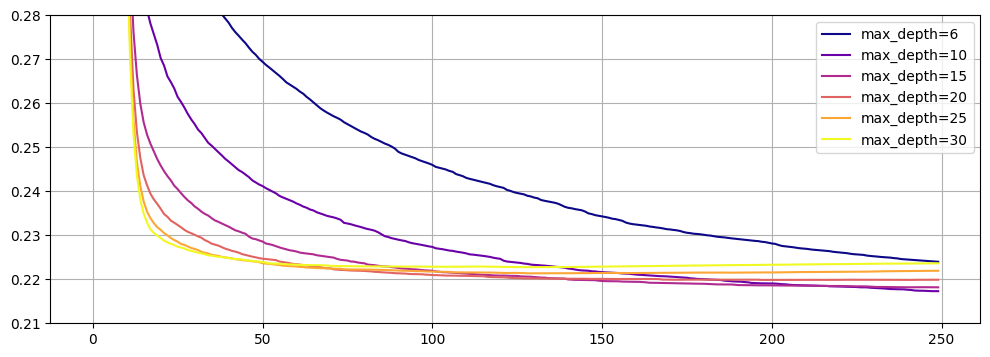

In [312]:
logs = output.stdout
scores_depth = plot_scores(logs, param_name="max_depth", tuned_param=tuned_param, ylim = [0.2, 0.28])

In [313]:
%%capture output

#optimized between max_depth 10, 15

params = {
    "eta": 0.3,
    "n_estimators": 250,
    # "max_depth": 6,
    "min_child_weight": 1,
    "nthread": -1,

    "objective": "reg:squarederror",
    "eval_metric": "rmse"

}

max_depths = [10, 11, 12, 13, 14, 15]
tuned_param = max_depths

training_metrics = []

for p in tqdm(tuned_param):
    scores = {}
    scores["params"], scores["rmse"], scores["mape"], scores["mae"] = train_linear_model(df, model=XGBRegressor, max_depth=p, **params)
    
    training_metrics.append(scores)

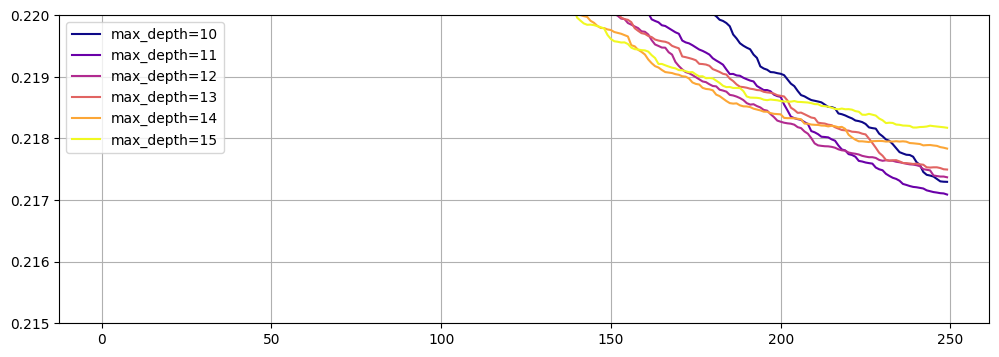

In [321]:
logs = output.stdout
scores_depth_fin = plot_scores(logs, param_name="max_depth", tuned_param=tuned_param, ylim = [0.215, 0.22])

In [45]:
%%capture output

# optimized max_depth = 12

params = {
    # "eta": 0.3,
    "n_estimators": 250,
    "max_depth": 12,
    "min_child_weight": 1,
    "nthread": -1,

    "objective": "reg:squarederror",
    "eval_metric": "rmse"

}

etas = [0.05, 0.1, 0.2, 0.3, 0.4]

tuned_param = etas

training_metrics = []

for p in tqdm(tuned_param):
    scores = {}
    scores["params"], scores["rmse"], scores["mape"], scores["mae"] = train_linear_model(df, model=XGBRegressor, eta=p, **params)
    
    training_metrics.append(scores)

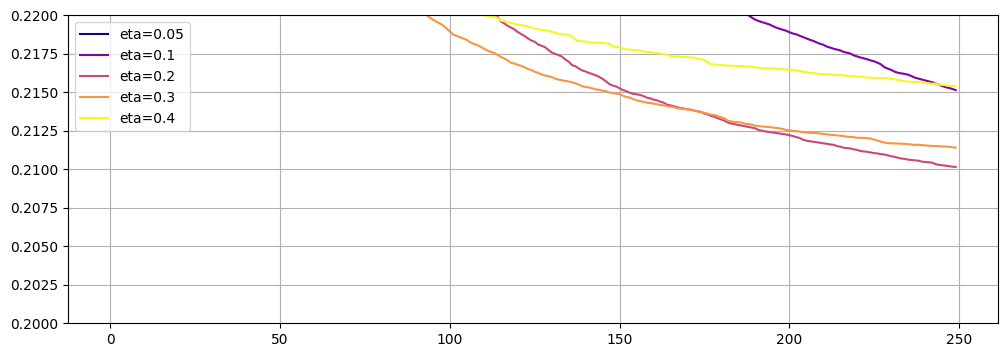

In [53]:
logs = output.stdout
scores_eta = plot_scores(logs, param_name="eta", tuned_param=tuned_param, ylim = [0.20, 0.22])

In [57]:
%%capture output

# optimized learning_rate = 0.2

params = {
    "eta": 0.2,
    "n_estimators": 250,
    "max_depth": 12,
    # "min_child_weight": 1,
    "nthread": -1,

    "objective": "reg:squarederror",
    "eval_metric": "rmse"

}

min_child_weight = [1, 2, 3, 4, 5, 6, 7, 8]

tuned_param = min_child_weight

training_metrics = []

for p in tqdm(tuned_param):
    scores = {}
    scores["params"], scores["rmse"], scores["mape"], scores["mae"] = train_linear_model(df, model=XGBRegressor, min_child_weight=p, **params)
    
    training_metrics.append(scores)

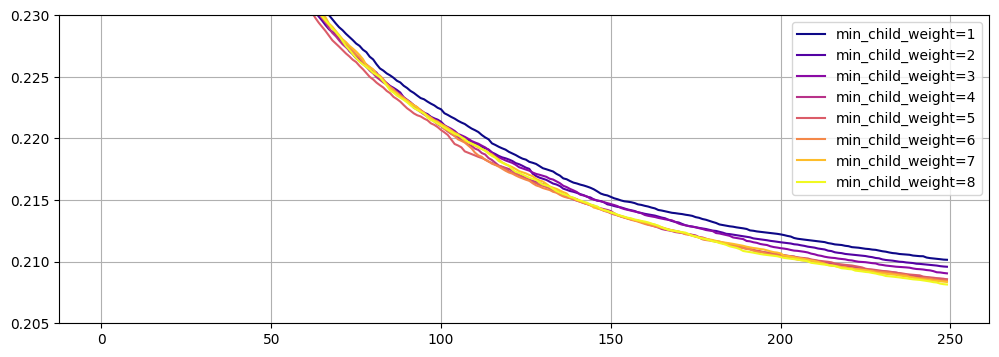

In [71]:
logs = output.stdout
scores_child = plot_scores(logs, param_name="min_child_weight", tuned_param=tuned_param, ylim = [0.205, 0.23])

In [83]:
scores_child[8]

,n_iter,train-rmse,valid-rmse
0,0,7.024676,7.024750
1,1,5.625446,5.625534
2,2,4.506610,4.506758
3,3,3.612302,3.612496
4,4,2.897736,2.898106
...,...,...,...
245,245,0.173296,0.208338
246,246,0.173216,0.208308
247,247,0.173070,0.208222
248,248,0.172932,0.208174


In [84]:
params = {
    "eta": 0.2,
    "n_estimators": 250,
    "max_depth": 12,
    "min_child_weight": 8,
    "nthread": -1,

    "objective": "reg:squarederror",
    "eval_metric": "rmse"

}

model = XGBRegressor

df_full_train = df.copy()
y_full_train = df_full_train.pop("sellingprice")

numerical_features = df_full_train.select_dtypes("number").columns.to_list()

ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1)

df_full_train["seller"] = ordinal.fit_transform(df_full_train["seller"].values.reshape(-1,1))

scaler = StandardScaler()

df_full_train[numerical_features + ["seller"]] = scaler.fit_transform(df_full_train[numerical_features + ["seller"]])

dict_full_train = df_full_train.to_dict(orient="records")
               
dv = DictVectorizer(sparse=True)
X_full_train = dv.fit_transform(dict_full_train)

regressor = model(**params)

regressor.fit(X_full_train, y_full_train)

y_predict = regressor.predict(X_full_train)

In [87]:
mean_squared_error(y_predict, y_full_train, squared=False)

0.17257201692672317

In [110]:
test_data = pd.read_csv("./dataset/car_prices_test.csv", sep=',', header='infer')

df_test = data_preprocession(test_data, features=features)
y_test = df_test.pop("sellingprice")

numerical_features = df_test.select_dtypes("number").columns.to_list()

df_test["seller"] = ordinal.transform(df_test["seller"].values.reshape(-1,1))
df_test[numerical_features + ["seller"]] = scaler.transform(df_test[numerical_features + ["seller"]])

dict_df_test = df_test.to_dict(orient="records")

X_test = dv.transform(dict_df_test)

y_test_predict = regressor.predict(X_test)

print(mean_squared_error(y_test, y_test_predict, squared=False))

0.2058278207344064
